In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle':'--'})

In [2]:
# helper functions
def simple_loss(theta):
    # 1D example, f(\theta) = (\theta - 5)^2
    return (theta - 5)**2

def simple_loss_gradient(theta):
    return 2*(theta - 5)

def loglikelihood_gaussian(theta, X):
    """
    calculate the log likelihood of a univariate gaussian. 
    theta = (mu, var)
    The final output will be inverse, in order to minimize it
    """
    N = X.shape[0]
    mu, var = theta  # un-pack the parameters
    ll = - 1.* N / 2 * np.log(2 * np.pi * var) - 1./ (2 * var) * np.square(X - mu).sum()
    
    return -1*ll

def loglikelihood_gaussian_gradient(theta, X):
    """
    calculate the gradient of the log likelihood for a univariate gaussian
    theta = (mu, var)
    """
    N = X.shape[0]
    mu, var = theta
    d_mu = 1. / var * (X - mu).sum()
    d_var = - 1.*N / 2 / var + (np.square(X - mu)).sum() / 2 / var**2
    # make sure d_var is less than var
    d_var = min(d_var, var - 1e-7)
    
    return -1*np.array([d_mu, d_var])

def backtrack_line_search(loss_fn, guess, gradient, 
                          init_step_size, tau=0.5, c=0.5, max_iter=30, **kwargs):
    """
    refer the symbols to wiki page
    https://en.wikipedia.org/wiki/Backtracking_line_search
    """
    step_size = init_step_size  # it is the \alpha
    m = np.linalg.norm(gradient)
    for j in range(max_iter):
        current_loss = loss_fn(guess, **kwargs)
        tmp_loss = loss_fn(guess - step_size*gradient, **kwargs)   
#         print('loss: ', current_loss, tmp_loss)
        if tmp_loss - current_loss < -1*step_size*c*m:
            break
        step_size *= tau
        tmp_loss = loss_fn(guess - step_size*gradient, **kwargs)    
    return step_size

def gradient_descent(loss_fn, grad_fn, init_guess, step_size, max_iter, 
                     tolerance=1e-4, step_size_fn=None, **kwargs):
    all_loss = []
    all_guess = []
    
    current_guess = init_guess
    current_loss = loss_fn(current_guess, **kwargs)
    all_loss.append(current_loss)
    all_guess.append(current_guess)
    init_step_size = step_size
    
    for i in range(max_iter):
        # get the gradient (vector)
        gradient = grad_fn(current_guess, **kwargs)
        
        # choose the step size, if provided
        if step_size_fn is None:
            delta = step_size * gradient
        else:
            step_size = step_size_fn(loss_fn, current_guess, gradient, 
                                     init_step_size, **kwargs)
            delta = step_size * gradient
#         print('step size: ', step_size)
        current_guess = np.copy(current_guess - delta) # don't use -=!
        
        # some book keeping:
        current_loss = loss_fn(current_guess, **kwargs)
        all_loss.append(current_loss)
        all_guess.append(current_guess)
        
        # tolerance check
        diff = abs(all_loss[-1] - all_loss[-2])
        if diff < tolerance:
            print("Reach tolerance bound at iteration {}, before max iteration of {}."
                 .format(i+1, max_iter))
            break
        
    return all_guess, all_loss

## Simple 1D case <a name='1d_case'></a>
### good step size

Reach tolerance bound at iteration 29, before max iteration of 50.


<IPython.core.display.Javascript object>


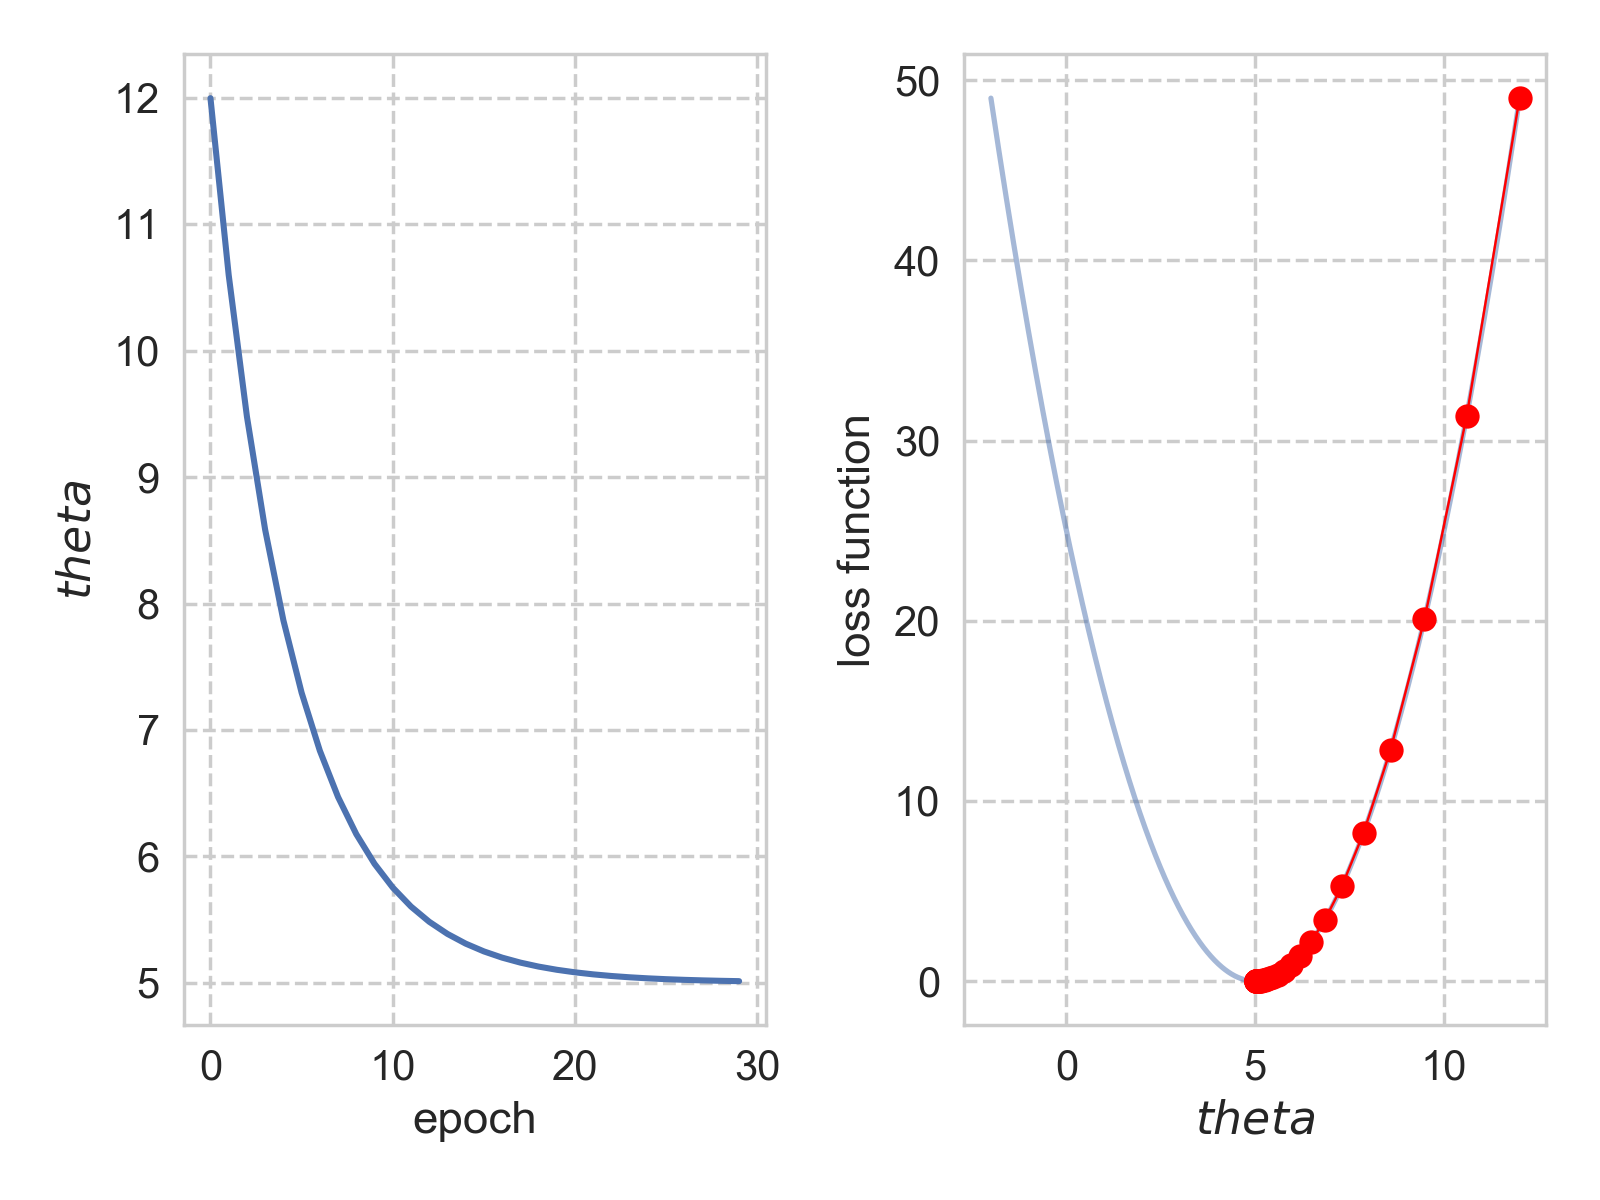

In [3]:
def plot_1d(all_guess, all_loss, fig_num):
    plt.close(fig_num); plt.figure(fig_num)
    # plot values at each epoch
    plt.subplot(121)
    plt.plot(all_guess)
    plt.xlabel("epoch"); plt.ylabel("$theta$")

    # plot the path
    x = np.linspace(-2, 12, 1001)
    plt.subplot(122)
    plt.plot(x, simple_loss(x), alpha=0.5, lw=1.5)
    plt.xlabel("$theta$"); plt.ylabel("loss function")
    plt.plot(all_guess, all_loss, 'ro-', lw=0.7)
    plt.tight_layout()
    plt.show()
    
all_guess_1d_good, all_loss_1d_good = gradient_descent(loss_fn=simple_loss, 
                                       grad_fn=simple_loss_gradient, 
                                       init_guess=12., 
                                       step_size=0.1, 
                                       max_iter=50,)
plot_1d(all_guess_1d_good, all_loss_1d_good, 0)

### bad step size

<IPython.core.display.Javascript object>


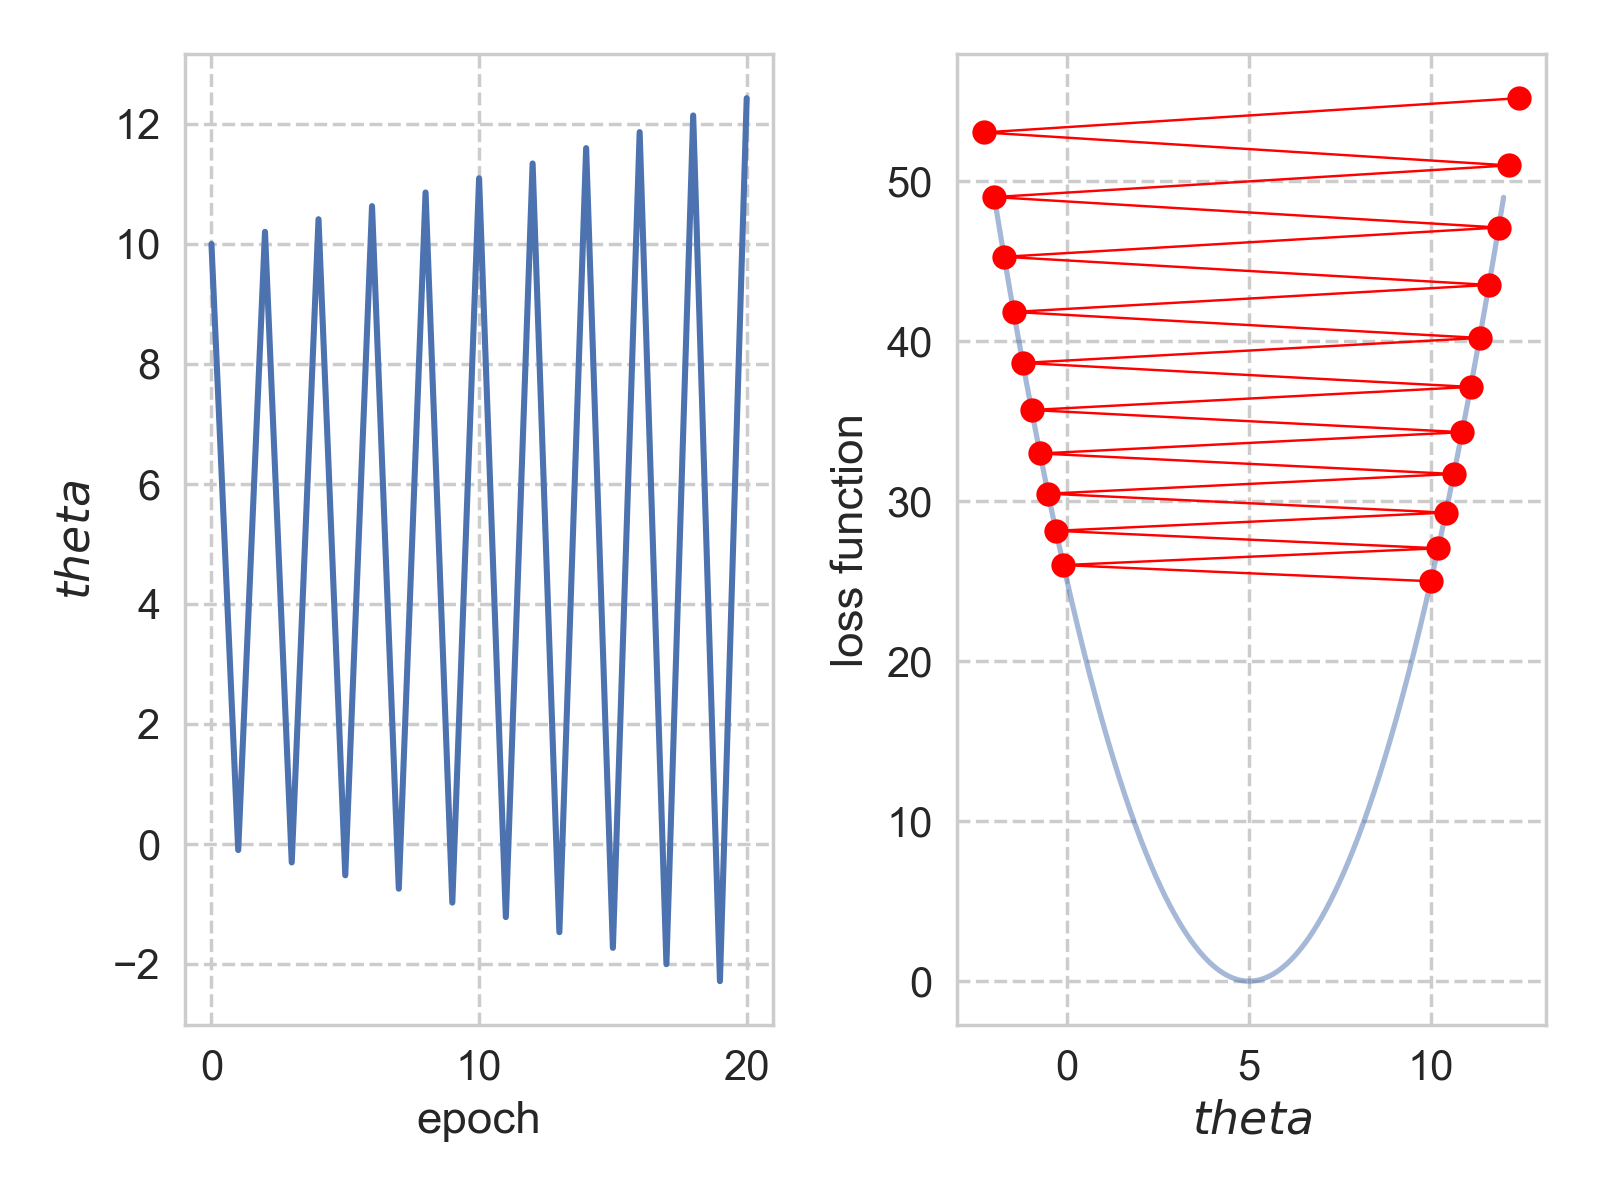

In [4]:
all_guess_1d_bad, all_loss_1d_bad = gradient_descent(loss_fn=simple_loss, 
                                       grad_fn=simple_loss_gradient, 
                                       init_guess=10., 
                                       step_size=1.01, 
                                       step_size_fn=None,
                                       max_iter=20,)
plot_1d(all_guess_1d_bad, all_loss_1d_bad, 1)

### backtrack line search with bad step size

Reach tolerance bound at iteration 5, before max iteration of 30.


<IPython.core.display.Javascript object>


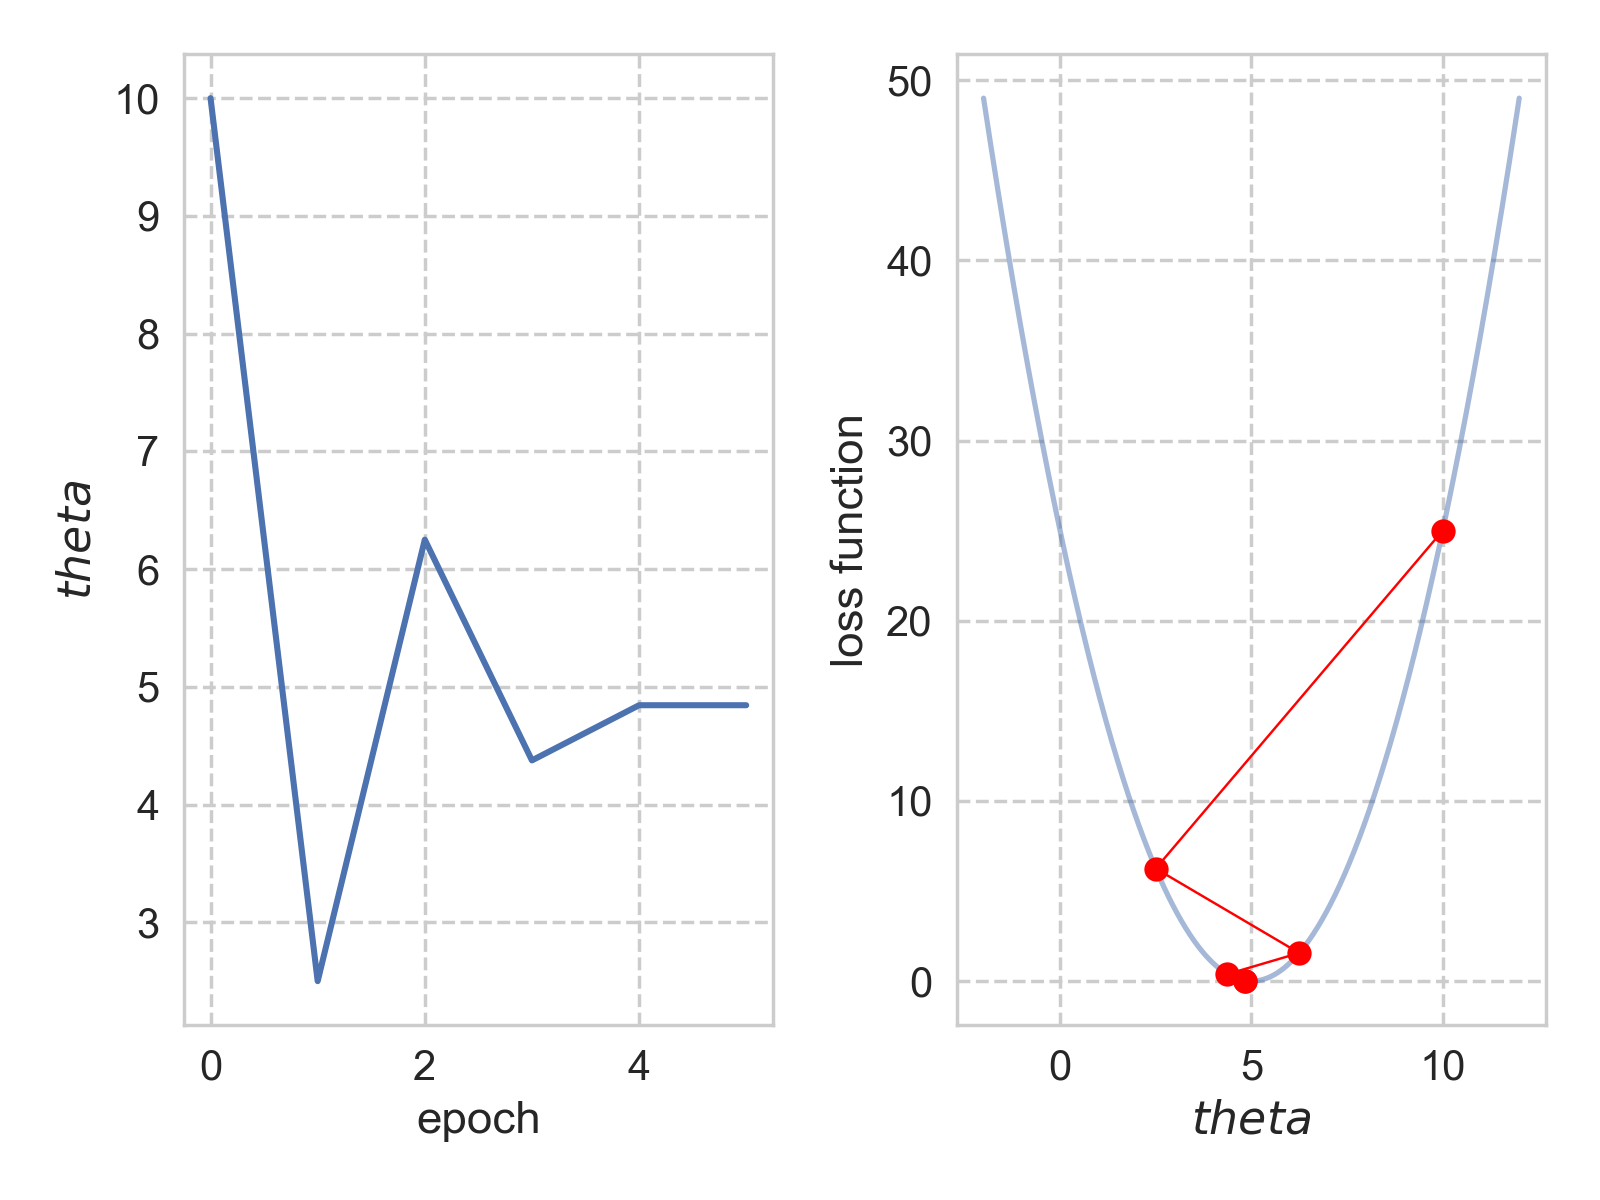

In [5]:
all_guess_1d_bls, all_loss_1d_bls = gradient_descent(loss_fn=simple_loss, 
                                       grad_fn=simple_loss_gradient, 
                                       init_guess=10., 
                                       step_size=1.5, 
                                       step_size_fn=backtrack_line_search,
                                       max_iter=30,)
plot_1d(all_guess_1d_bls, all_loss_1d_bls, 2)

In [6]:
## combine all 3 cases
def plot_loss_and_path_1d(all_path={}, fig_num=50):
    N = len(all_path)
    labels, paths, losses = [], [], []
    for k in all_path:
        labels.append(k)
        paths.append(all_path[k][0])
        losses.append(all_path[k][1])
    max_path = max([len(x) for x in paths])
    figure_max = min(max_path, 15)  # at most plot n figures
    
    # make loss function
    x = np.linspace(-2, 12, 1001)
    loss = simple_loss(x)
    
    for i in range(figure_max):  
        # plot the background loss function
        plt.figure(fig_num)
        plt.plot(x, loss, alpha=0.3, lw=1.5, color='navy')
        plt.xlabel("$theta$"); plt.ylabel("loss function")
        # loop through all the paths
        for k in range(N):
            plt.plot(paths[k][:i], losses[k][:i], 'o-', label=labels[k])
        plt.legend()
        plt.savefig('figure_{}.png'.format(fig_num))
        plt.close(fig_num)
        fig_num += 1

all_path = {'good': [all_guess_1d_good, all_loss_1d_good],
            'bad': [all_guess_1d_bad, all_loss_1d_bad],
            'line search': [all_guess_1d_bls, all_loss_1d_bls]}
# plot_loss_and_path_1d(all_path)

## 2D case: fitting a gaussian <a name='2d_case'></a>

<IPython.core.display.Javascript object>


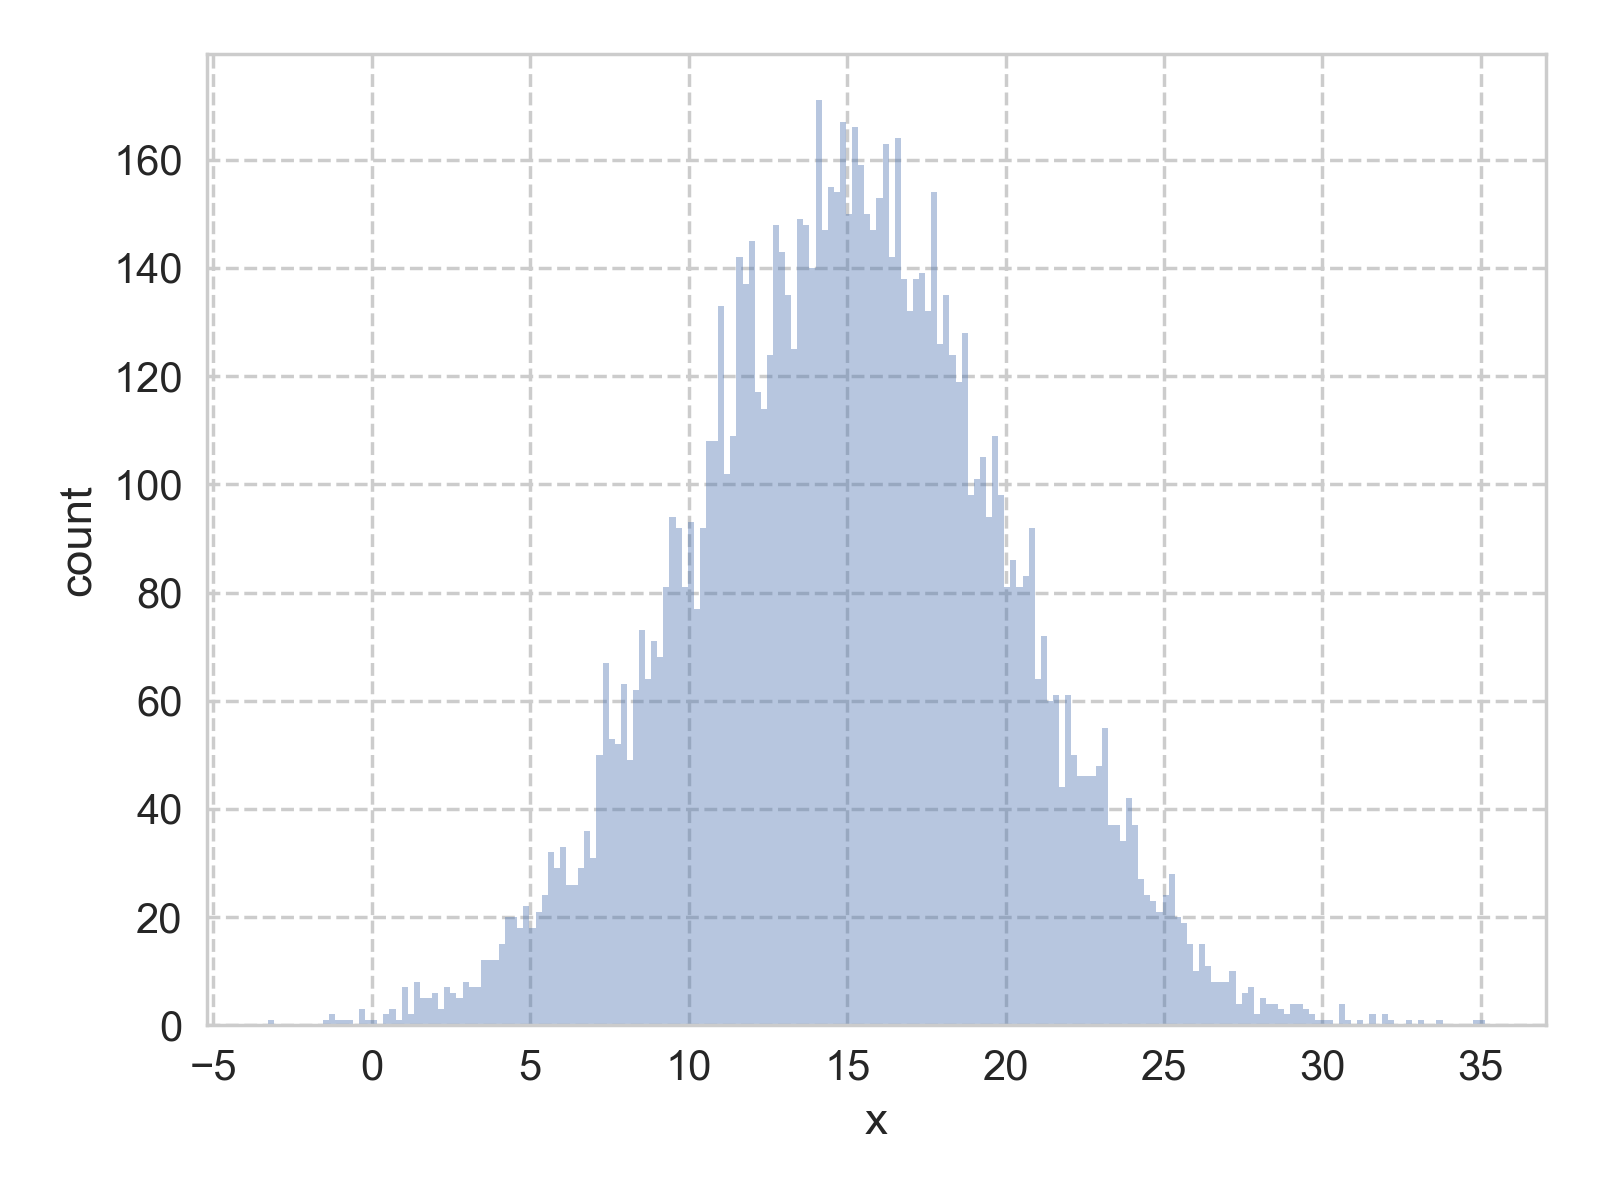

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [7]:
np.random.seed(1)
X = np.random.normal(15, 5, 10000)
plt.close(10); plt.figure(10)
sns.distplot(X, bins=200, kde=False)
plt.xlabel('x'); plt.ylabel('count')
plt.tight_layout()
plt.show()

### good step size

Reach tolerance bound at iteration 914, before max iteration of 1000.


<IPython.core.display.Javascript object>


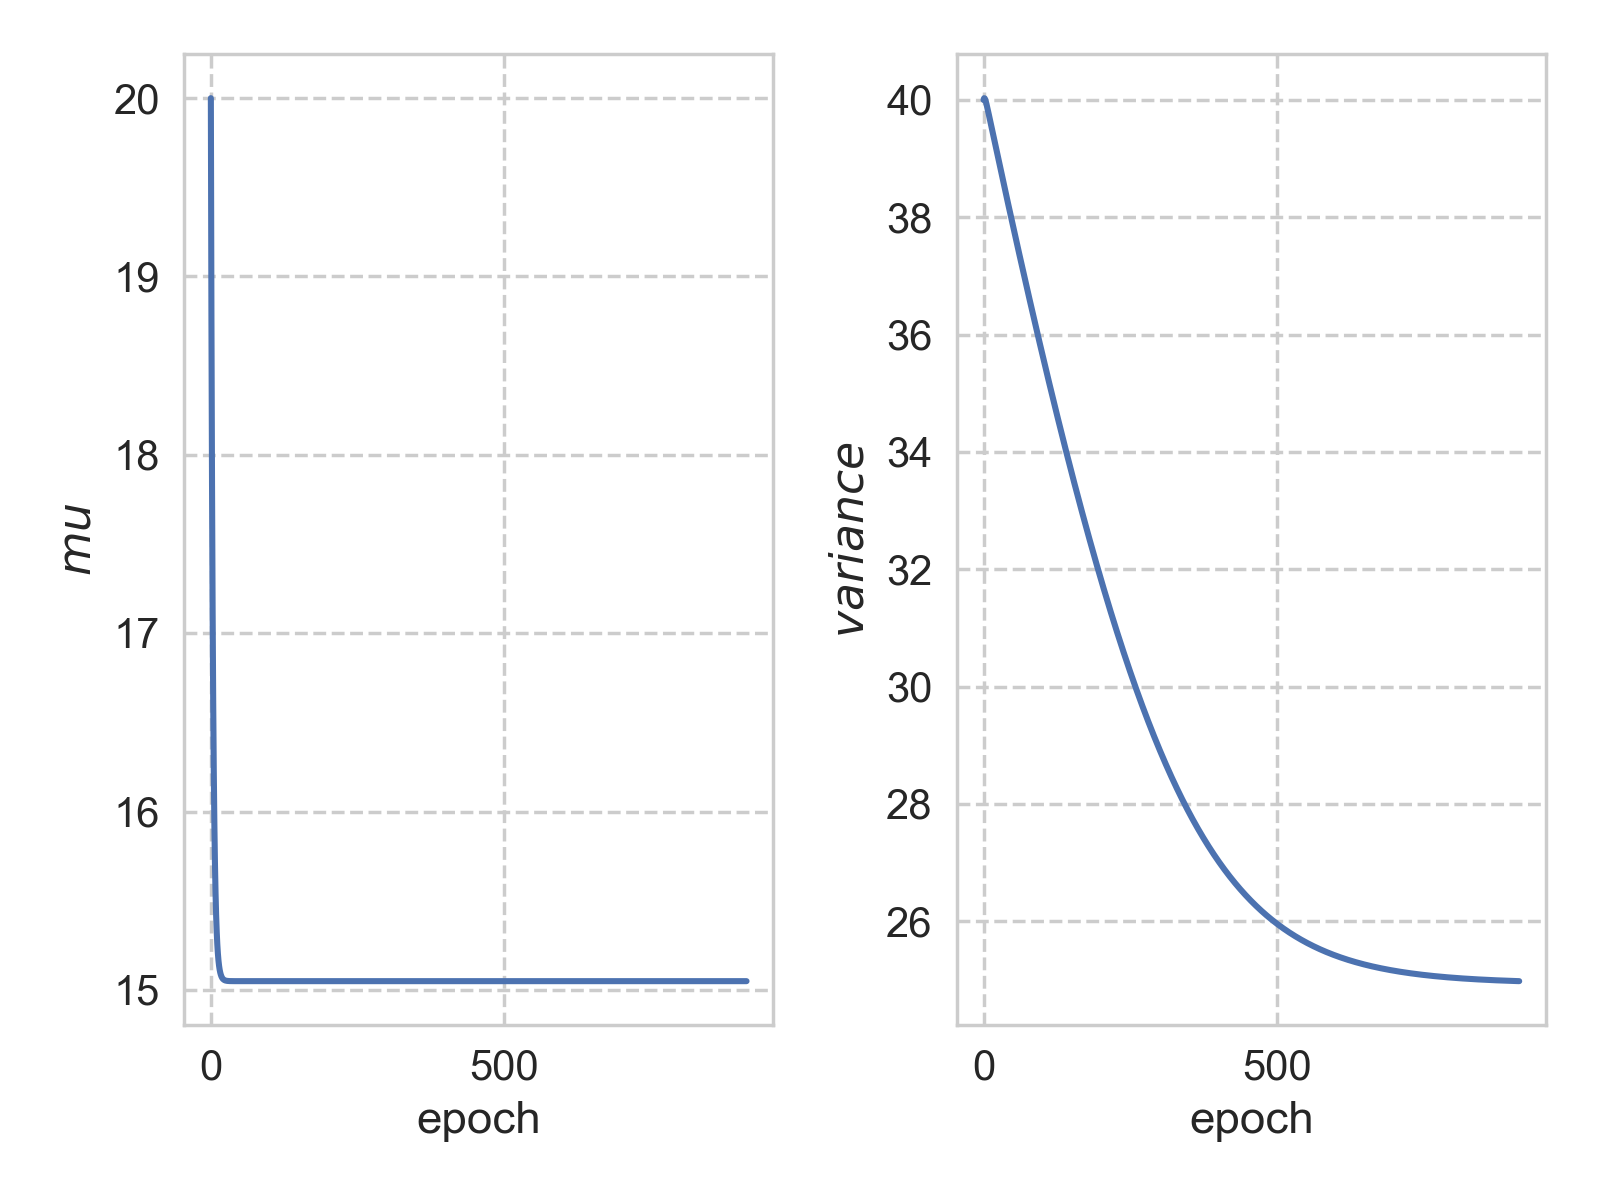

<IPython.core.display.Javascript object>


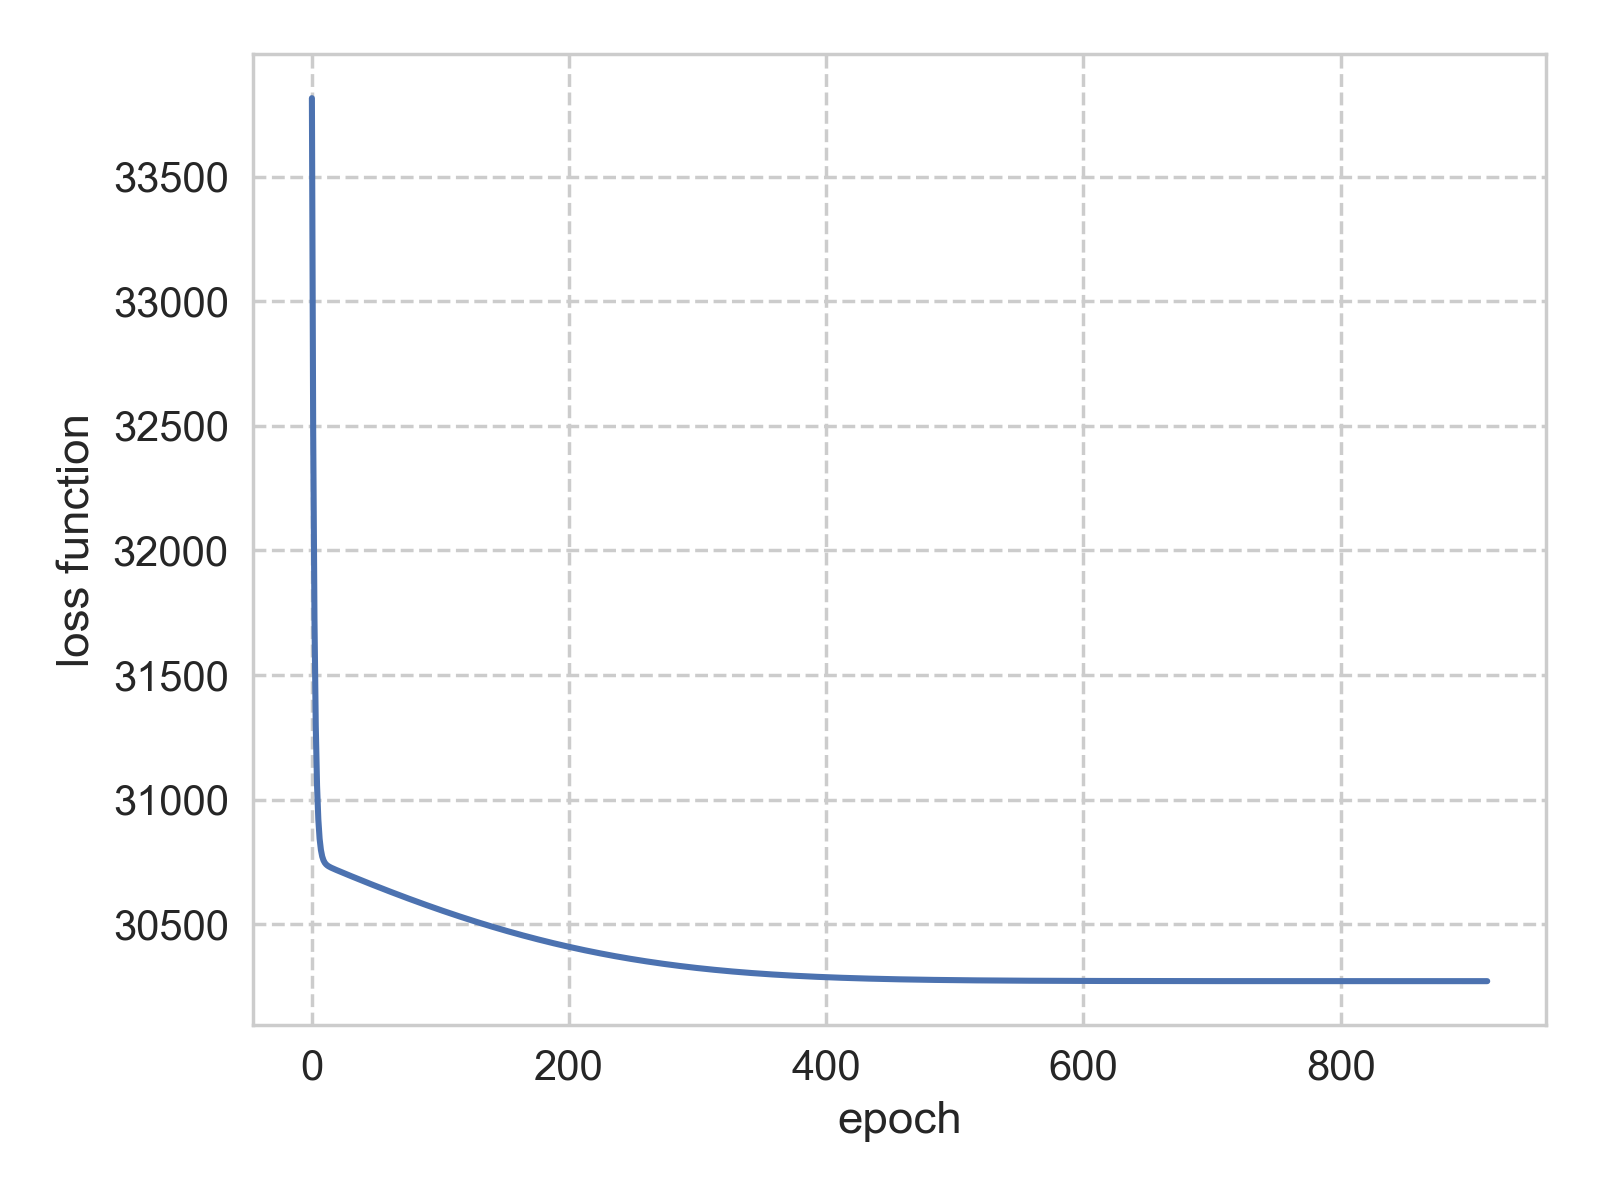

In [8]:
def plot_2d(all_guess, all_loss, fig_num):
    plt.close(fig_num); plt.figure(fig_num)
    plt.subplot(121)
    plt.plot([x[0] for x in all_guess])
    plt.xlabel("epoch"); plt.ylabel('$mu$')
    plt.subplot(122)
    plt.plot([x[1] for x in all_guess])
    plt.xlabel("epoch"); plt.ylabel('$variance$')
    plt.tight_layout()
    plt.show()

    plt.close(fig_num+1); plt.figure(fig_num+1)
    plt.plot(all_loss)
    plt.xlabel("epoch"); plt.ylabel('loss function')
    plt.tight_layout()
    plt.show()

all_guess_2d_good, all_loss_2d_good = gradient_descent(loss_fn=loglikelihood_gaussian, 
                                       grad_fn=loglikelihood_gaussian_gradient, 
                                       init_guess=np.array([20., 40.]), 
                                       step_size=0.001, 
                                       max_iter=1000,
                                       tolerance=1e-4,
                                       step_size_fn=None,
                                       X=X)
plot_2d(all_guess_2d_good, all_loss_2d_good, 11)

### bad step size

<IPython.core.display.Javascript object>


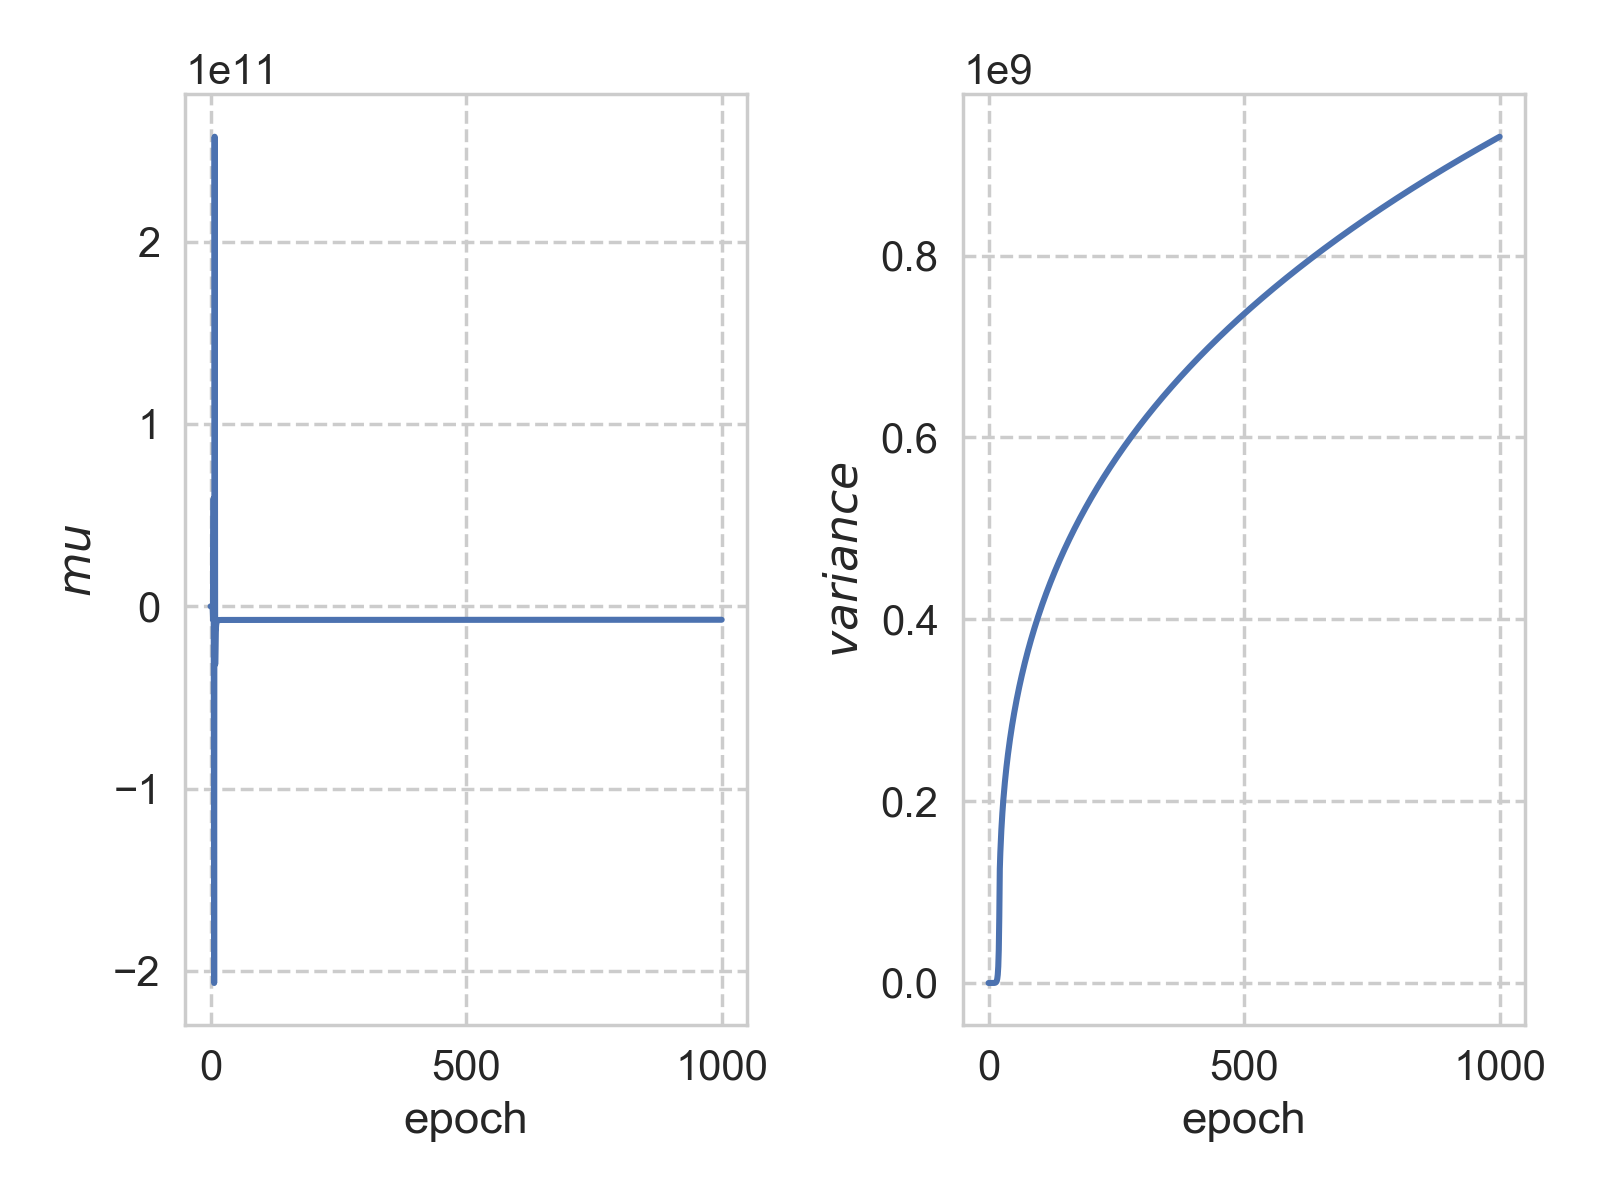

<IPython.core.display.Javascript object>


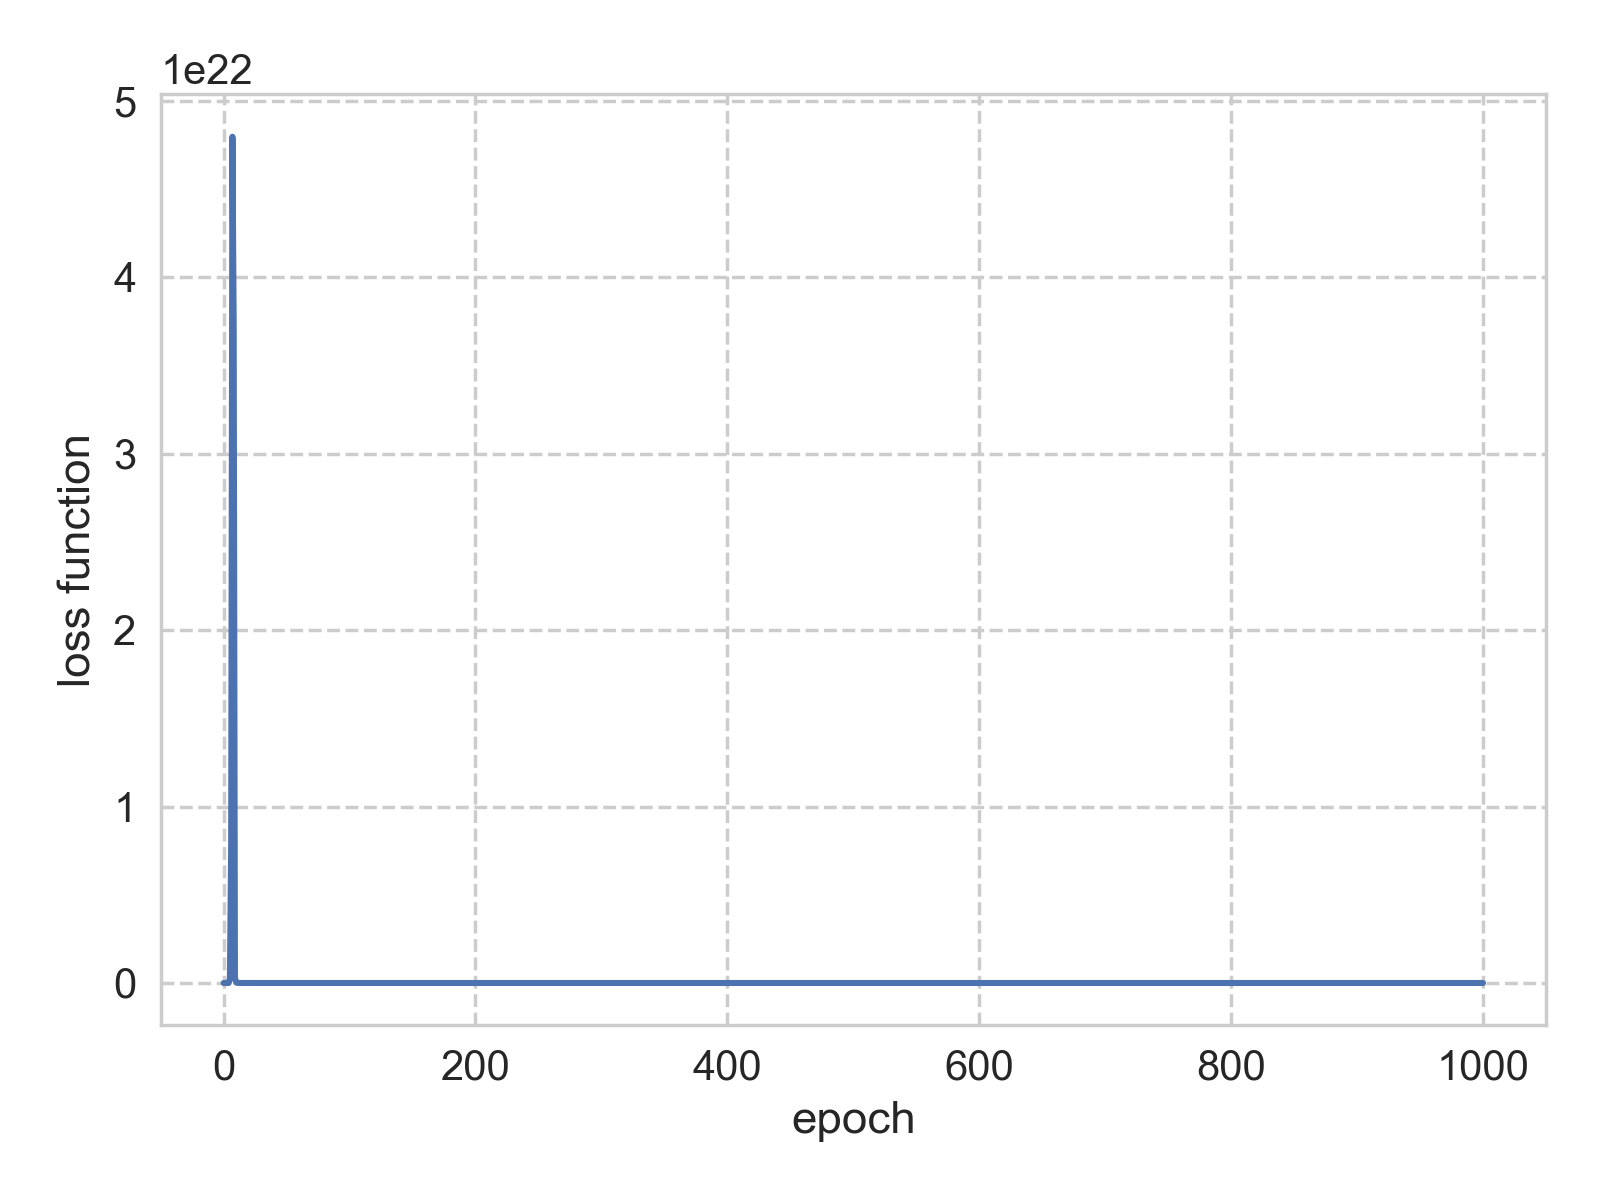

In [9]:
all_guess_2d_bad, all_loss_2d_bad = gradient_descent(loss_fn=loglikelihood_gaussian, 
                                       grad_fn=loglikelihood_gaussian_gradient, 
                                       init_guess=np.array([20., 40.]), 
                                       step_size=1, 
                                       max_iter=1000,
                                       tolerance=1e-4,
                                       step_size_fn=None,
                                       X=X)
plot_2d(all_guess_2d_bad, all_loss_2d_bad, 21)

### bad step size, with backtrack line search

Reach tolerance bound at iteration 103, before max iteration of 1000.


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in log


<IPython.core.display.Javascript object>


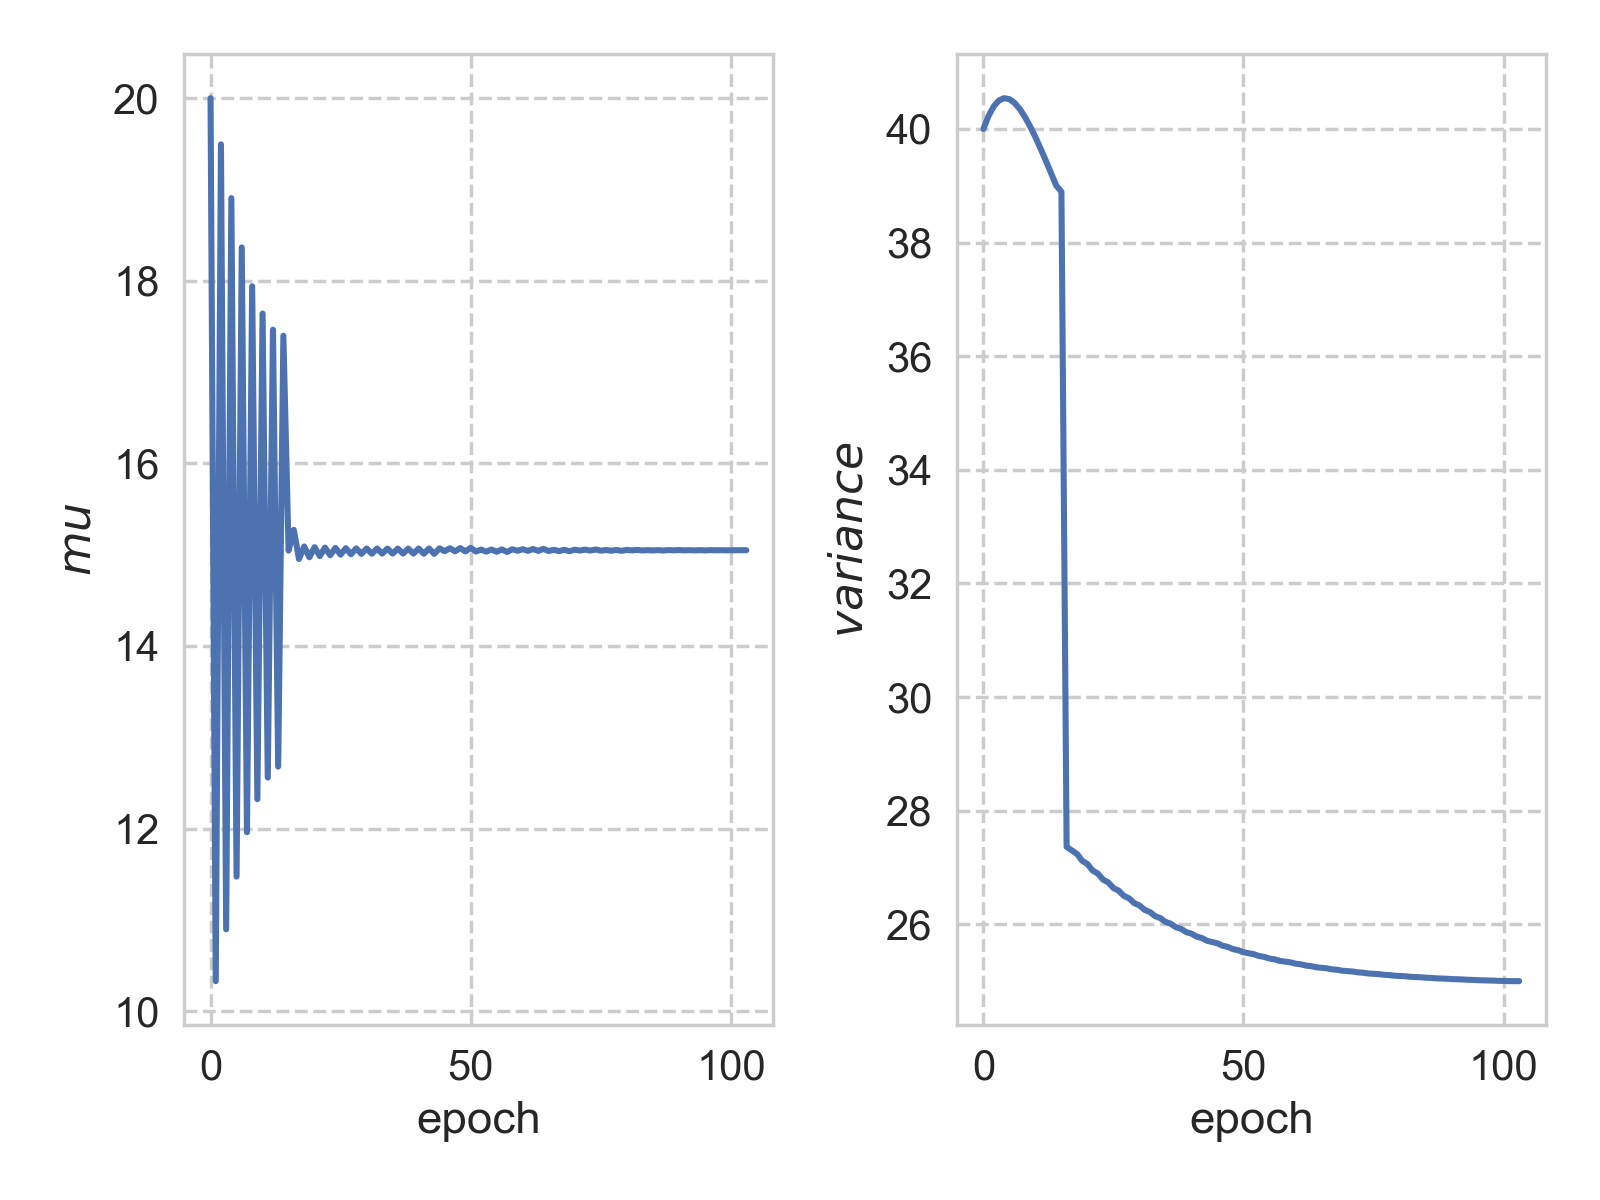

<IPython.core.display.Javascript object>


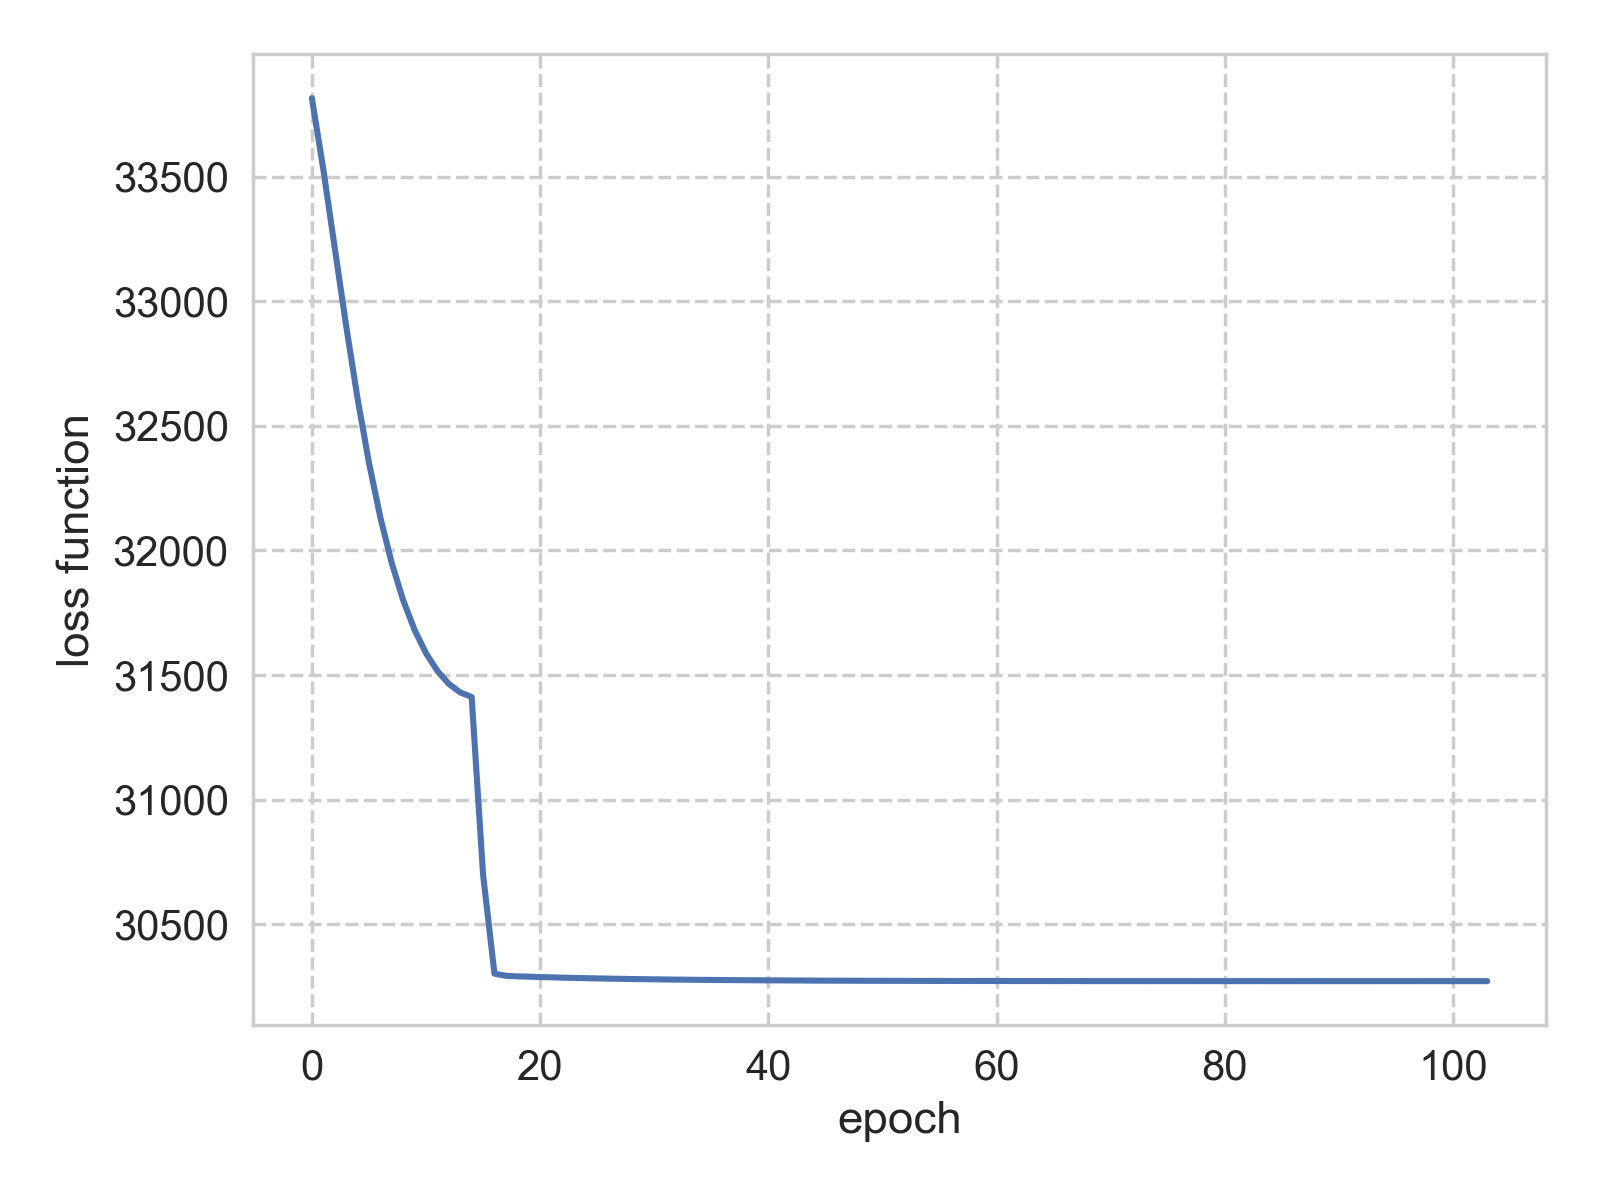

In [10]:
all_guess_2d_bls, all_loss_2d_bls = gradient_descent(loss_fn=loglikelihood_gaussian, 
                                       grad_fn=loglikelihood_gaussian_gradient, 
                                       init_guess=np.array([20., 40.]), 
                                       step_size=1, 
                                       max_iter=1000,
                                       tolerance=1e-4,
                                       step_size_fn=backtrack_line_search,
                                       X=X)
plot_2d(all_guess_2d_bls, all_loss_2d_bls, 31)

In [11]:
## put all the cases together
def val_2_idx(values, idx_min, idx_max, val_min, val_max):
    slope = (idx_max - idx_min)/(val_max - val_min)
    idx_plot = [-val_min*slope + x*slope for x in values]
    return idx_plot

def plot_loss_and_path_2d(all_path={}, fig_num=50):
    
    ## loss function 
    n_mu = 201
    n_var = 401
    raw_data = []
    losses = np.ndarray(shape=(n_mu, n_var))
    for i, mu in enumerate(np.linspace(5, 25, n_mu)):
        for j, var in enumerate(np.linspace(5, 45, n_var)):
            raw_data.append([mu, var, loglikelihood_gaussian([mu, var], X)])

    df_loss = pd.DataFrame(data=raw_data, columns=['mu', 'var', 'loss'])
    df_loss = df_loss.pivot(index='mu', columns='var', values='loss')
    
    N = len(all_path)
    labels, paths, losses = [], [], []
    for k in all_path:
        labels.append(k)
        scaled_mu = val_2_idx([x[0] for x in all_path[k][0]], 0, df_loss.shape[0],
                          df_loss.index.min(), df_loss.index.max())    
        scaled_var = val_2_idx([x[1] for x in all_path[k][0]], 0, df_loss.shape[1],
                              df_loss.columns.min(), df_loss.columns.max())
        paths.append([scaled_mu, scaled_var])
        losses.append(all_path[k][1])
    
    max_path = max([len(x[0]) for x in paths])
    figure_max = min(max_path, 50)  # at most plot n figures
    
        
    for i in range(figure_max):  
        # plot the background loss function
        plt.figure(fig_num)
        ax = sns.heatmap(df_loss, robust=True, cmap='YlGnBu',
                     xticklabels=n_var//4, yticklabels=n_mu//4)
        # loop through all the paths
        for k in range(N):
            plt.plot(paths[k][1][:i], paths[k][0][:i], '-', label=labels[k], alpha=0.5)
        plt.legend()
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig('figure_{}.png'.format(fig_num))
        plt.close(fig_num)
        fig_num += 1

#     print(paths)

all_path = {'good': [all_guess_2d_good, all_loss_2d_good],
            'bad': [all_guess_2d_bad, all_loss_2d_bad],
            'line search': [all_guess_2d_bls, all_loss_2d_bls]}
# plot_loss_and_path_2d(all_path)
# convert -background white -alpha remove -layers OptimizePlus -delay 15 figure_{50..99}.png gd_2d.gif